In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from sklearn.model_selection import cross_val_score
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

# USERS

In [2]:
users = pd.read_csv('users.csv', index_col=0) #import user table
frauds = pd.read_csv('fraudsters.csv', index_col=0) #import existing  fraudolent users

In [3]:
#Formatting of users column
users.columns = map(str.lower, users.columns) # columns name in lowercase 
users['created_date'] = pd.to_datetime(users['created_date']) #dates to datetime format
users['terms_version'] = pd.to_datetime(users['terms_version']) #dates to datetime format
phone = users['phone_country'].str.split(r'\||') #remove special characters
users['phone_country'] = phone.apply(lambda x: [x for x in set(x) if x]) # filter unique phone countries
users['num_phone'] = users['phone_country'].apply(lambda x: len(x)) #add column total number of phones
users['flag'] = users['id'].apply(lambda user: user in frauds['user_id'].tolist()) #add boolean frauds flag column 
users['has_email'] = users['has_email'].apply(lambda mail: mail==1) #boolean has_email
users = users.rename(columns={'id': 'user_id'}) #rename id to user_id in order to merge

In [4]:
users.head()

,failed_sign_in_attempts,kyc,birth_year,country,state,created_date,terms_version,phone_country,has_email,user_id,num_phone,flag
0,0,PASSED,1971,GB,ACTIVE,2017-08-06 07:33:33.341,2018-05-25,"[I, M, B, J, G, E]",True,1872820f-e3ac-4c02-bdc7-727897b60043,6,False
1,0,PASSED,1982,GB,ACTIVE,2017-03-07 10:18:59.427,2018-01-01,"[I, M, B, J, G, E]",True,545ff94d-66f8-4bea-b398-84425fb2301e,6,False
2,0,PASSED,1973,ES,ACTIVE,2018-05-31 04:41:24.672,2018-09-20,"[E, S]",True,10376f1a-a28a-4885-8daa-c8ca496026bb,2,False
3,0,PASSED,1986,FR,ACTIVE,2018-06-01 17:24:23.852,2018-05-25,"[F, R]",True,fd308db7-0753-4377-879f-6ecf2af14e4f,2,False
4,0,PASSED,1989,GB,ACTIVE,2017-08-09 15:03:33.945,2018-09-20,"[I, M, B, J, G, E]",True,755fe256-a34d-4853-b7ca-d9bb991a86d3,6,False


# Transactions

In [5]:
transactions = pd.read_csv('transactions.csv', index_col=0) #import transaction table

In [6]:
transactions.columns = map(str.lower, transactions.columns) # columns name in lowercase 
transactions['created_date'] = pd.to_datetime(transactions['created_date']) #dates to datetime format


In [7]:
transactions.head()

,currency,amount,state,created_date,merchant_category,merchant_country,entry_method,user_id,type,source,id
0,GBP,3738,COMPLETED,2015-10-11 09:05:43.016,bar,AUS,misc,7285c1ec-31d0-4022-b311-0ad9227ef7f4,CARD_PAYMENT,GAIA,5a9ee109-e9b3-4598-8dd7-587591e6a470
1,GBP,588,COMPLETED,2015-10-11 20:08:39.150,NaN,CA,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,CARD_PAYMENT,GAIA,28d68bf4-460b-4c8e-9b95-bcda9ab596b5
2,GBP,1264,COMPLETED,2015-10-11 11:37:40.908,NaN,UKR,misc,0fe472c9-cf3e-4e43-90f3-a0cfb6a4f1f0,CARD_PAYMENT,GAIA,1f1e8817-d40b-4c09-b718-cfc4a6f211df
3,GBP,66,REVERTED,2015-10-11 20:08:35.310,NaN,CA,misc,20100a1d-12bc-41ed-a5e1-bc46216e9696,CARD_PAYMENT,GAIA,a7aaf78c-d201-456f-9e6d-612a795e8c32
4,GBP,968,COMPLETED,2015-10-11 02:46:47.640,supermarket,NZL,misc,821014c5-af06-40ff-91f4-77fe7667809f,CARD_PAYMENT,GAIA,27dd99a2-5539-4ba9-876a-1a94abc2701f


# MERGE


In [8]:
user_transactions = transactions.merge(users, on='user_id') #create merged table from users and transactions

# USERS CHARACTERSTICS

In [9]:
user_f = users[users['flag']] # create dataframe with fraudolents users
user_nf = users[-users['flag']] # create dataframe with non-fraudolents users
demo_variables = ['failed_sign_in_attempts', 'kyc', 'country', 'state',
                'has_email','num_phone'] #demografic variables for exploratory data analysis (EDA)

In [10]:
def plot_demographic(variable): #function to plot EDA
    counts = user_f[variable].value_counts()/user_f[variable].value_counts().sum()
    counts = counts[:10,]
    plt.figure(figsize=(10,5))
    sns.barplot(counts.index, counts.values, alpha=0.8)
    plt.title(variable)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('STATE', fontsize=12)
    plt.show()
    counts = user_nf[variable].value_counts()/user_nf[variable].value_counts().sum()
    counts = counts[:10,]
    plt.figure(figsize=(10,5))
    sns.barplot(counts.index, counts.values, alpha=0.8)
    plt.title(variable+'---NON FREUDERS')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('STATE', fontsize=12)
    plt.show()


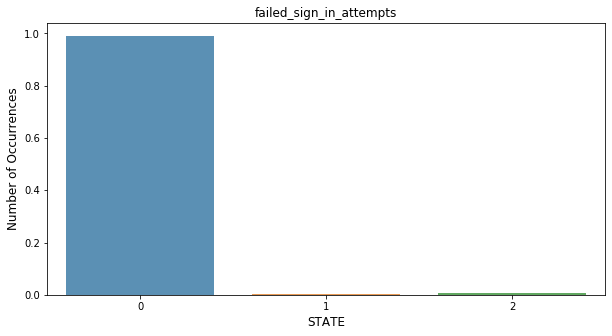

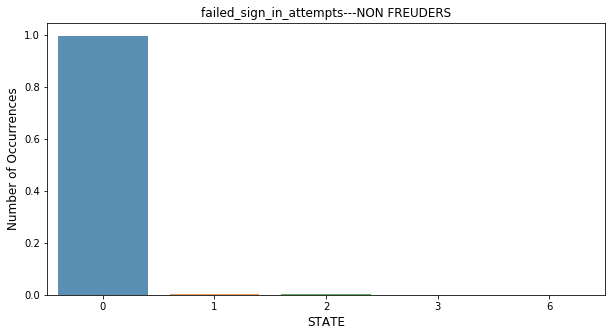

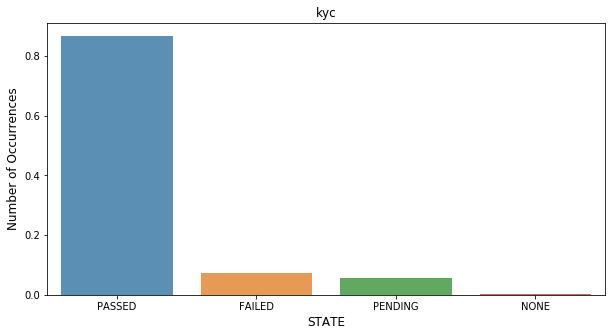

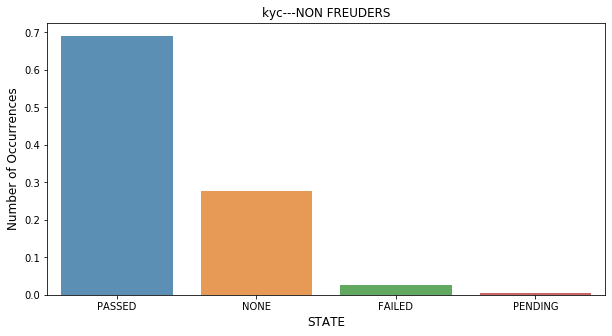

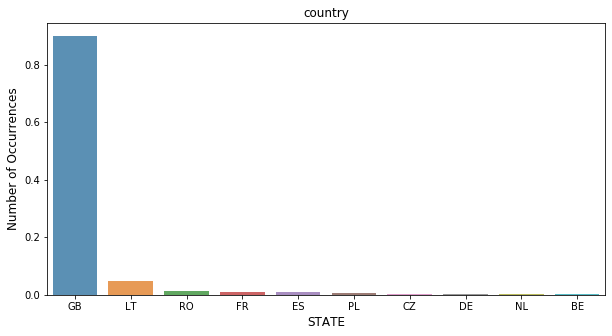

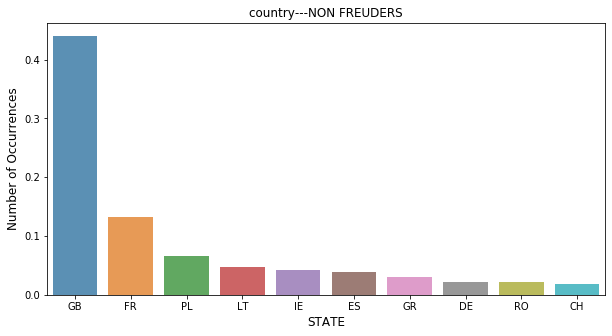

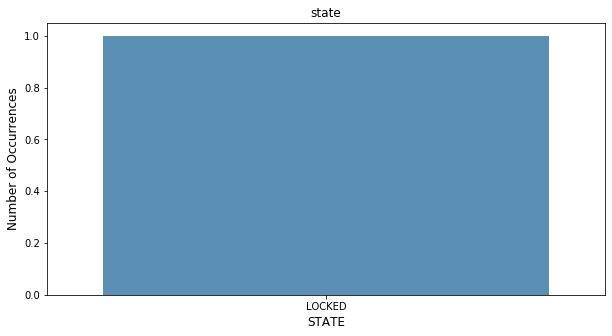

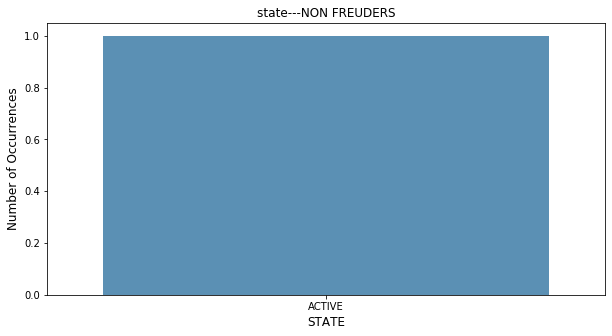

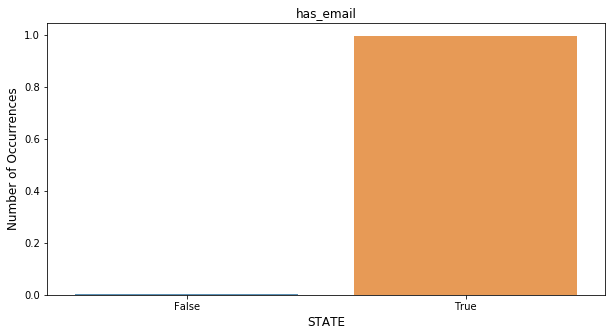

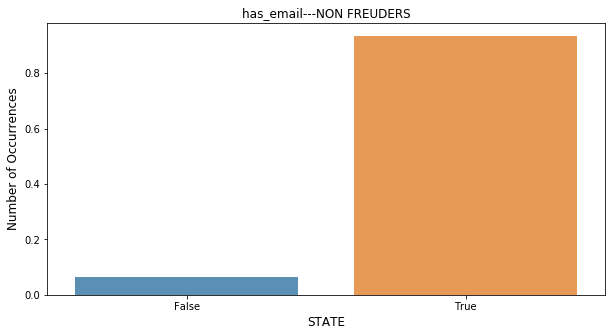

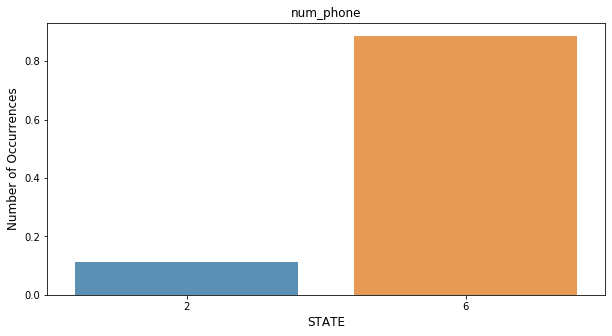

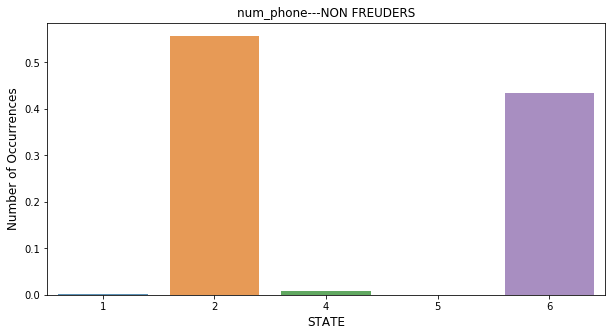

[None, None, None, None, None, None]

In [11]:
[plot_demographic(v) for v in demo_variables] #plotting EDA

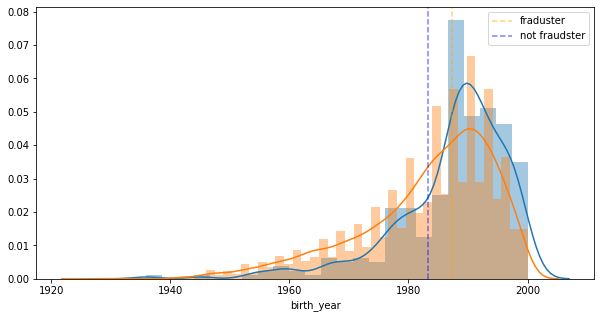

In [12]:
plt.figure(figsize=(10,5))
sns.distplot(user_f['birth_year']) #plotting distrubution of birth year of all users
sns.distplot(user_nf['birth_year'])
plt.axvline(user_f['birth_year'].mean(), color='orange',linestyle='--',alpha = 0.5)
plt.axvline(user_nf['birth_year'].mean(), color='blue',linestyle='--',alpha = 0.5)

plt.legend(['fraduster', 'not fraudster'])

plt.show()

## time series visualization

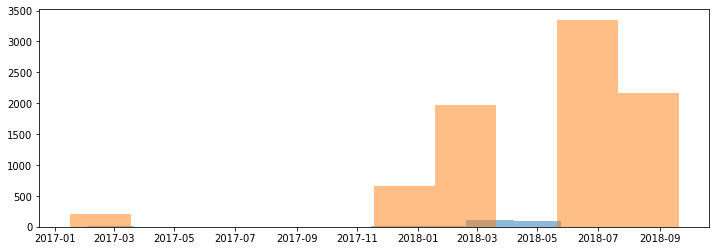

In [13]:
plt.figure(figsize=(12,4)) #plotting histograms of terms version of all users
plt.hist(user_f['terms_version'], normed=False, alpha=0.5)
plt.hist(user_nf['terms_version'], normed=False, alpha=0.5)
plt.show()

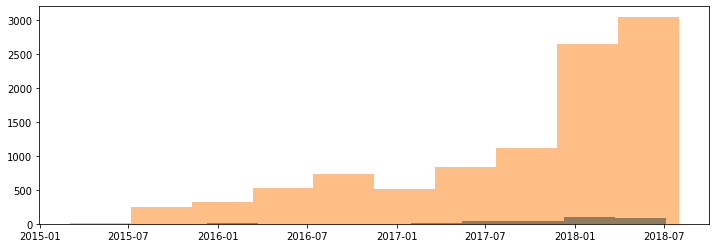

In [14]:
plt.figure(figsize=(12,4)) #plotting histograms of created date of all users
plt.hist(user_f['created_date'], normed=False, alpha=1)
plt.hist(user_nf['created_date'], normed=False, alpha=0.5)
plt.show()

# Transactions

In [15]:
user_transactionsf = user_transactions[user_transactions['flag']] # create dataframe with fraudolents transactions
user_transactionsnf = user_transactions[-user_transactions['flag']] # create dataframe with non-fraudolents transactions
tx_variables = ['currency', 'amount', 'state_x', 'merchant_category', #transaction variables for exploratory data analysis (EDA)
       'merchant_country', 'entry_method', 'type', 'source']

In [16]:
def plot_tx(variable): #function to plot EDA
    counts = user_transactionsf[variable].value_counts()/user_transactionsf[variable].value_counts().sum()
    counts = counts[:10,]
    plt.figure(figsize=(10,5))
    sns.barplot(counts.index, counts.values, alpha=0.8)
    plt.title(variable)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('STATE', fontsize=12)
    plt.show()
    counts = user_transactionsnf[variable].value_counts()/user_transactionsnf[variable].value_counts().sum()
    counts = counts[:10,]
    plt.figure(figsize=(10,5))
    sns.barplot(counts.index, counts.values, alpha=0.8)
    plt.title(variable+'---NON FREUDERS')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('STATE', fontsize=12)
    plt.show()

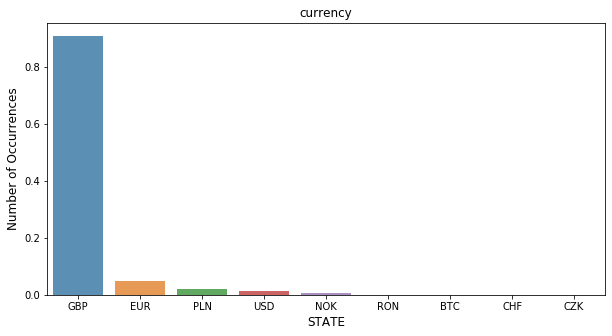

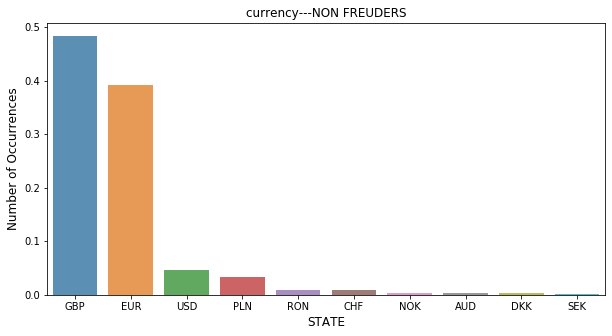

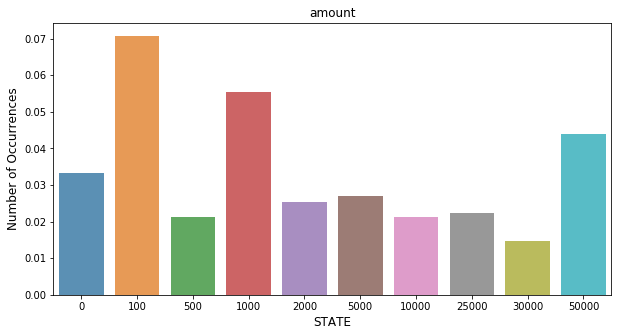

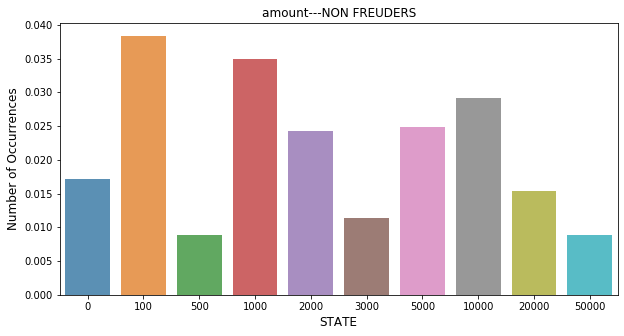

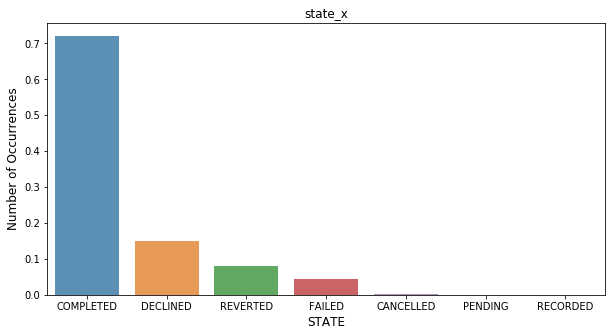

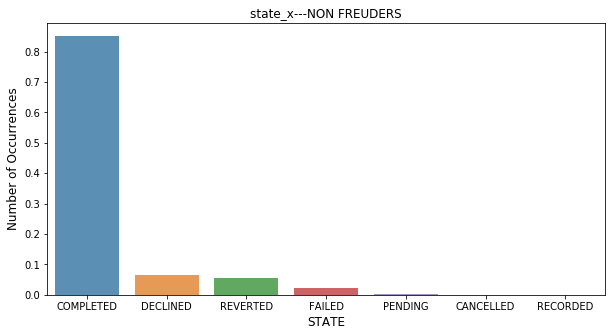

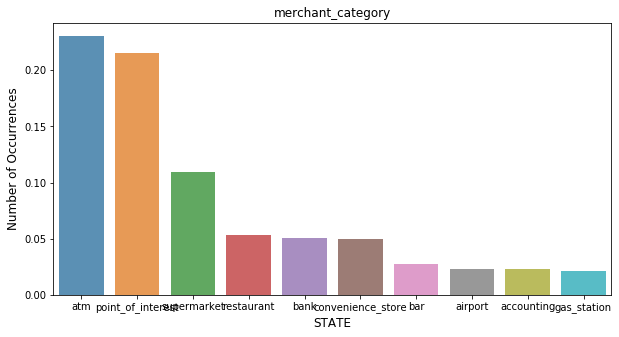

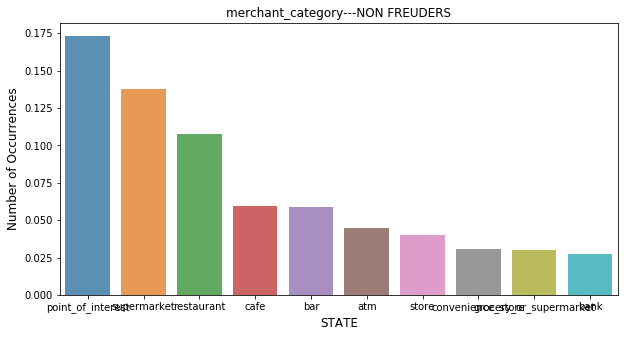

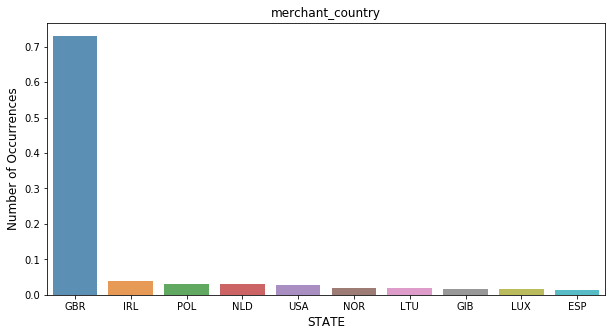

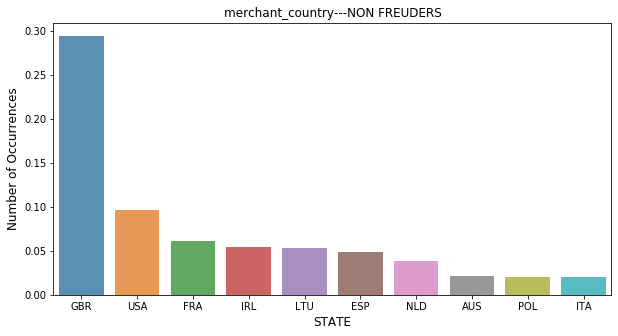

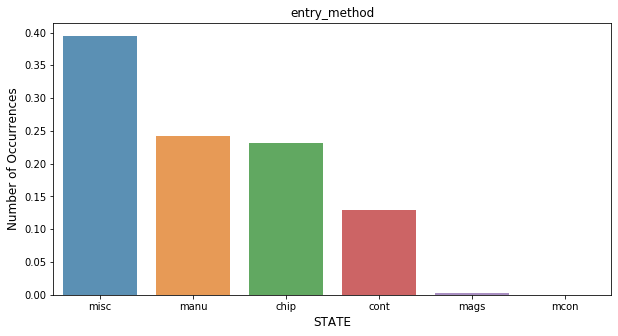

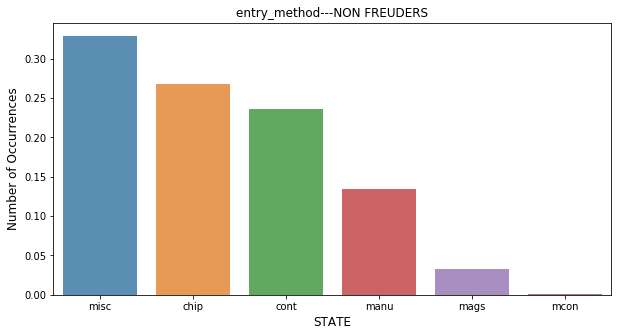

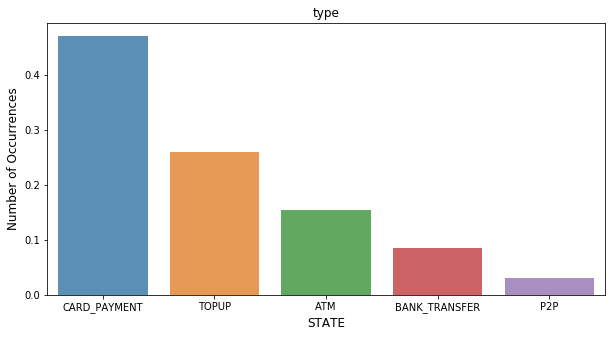

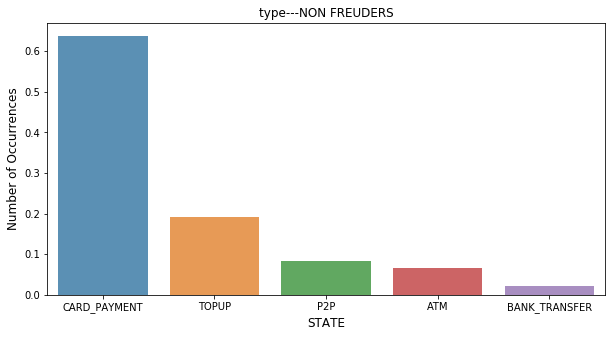

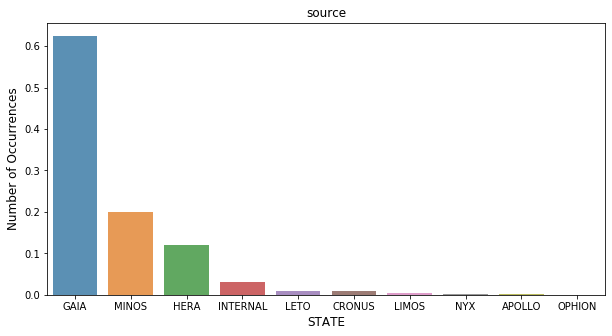

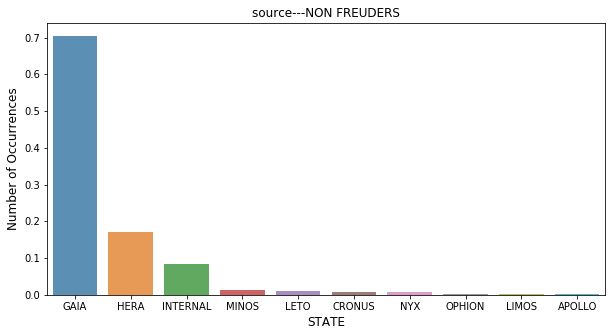

In [17]:
for v in tx_variables:
    plot_tx(v)

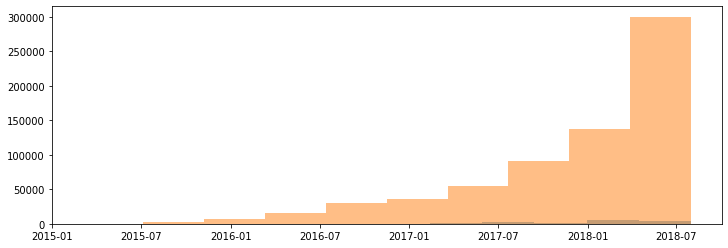

In [18]:
plt.figure(figsize=(12,4)) #plotting histograms of created date transaction of all users
plt.hist(user_transactionsf['created_date_x'], normed=False, alpha=0.5)
plt.hist(user_transactionsnf['created_date_x'], normed=False, alpha=0.5)
plt.show()

# FEATURE ENGENEERING

In [19]:
nulls = user_transactions.isna().sum() # calculate null ratios to remove variables 
nulls /= user_transactions.shape[0]
mask = nulls > 0
nulls = nulls.loc[mask]
nulls.sort_values(ascending=False)

#DO NOT INCLUDE  merchant_category, merchant_country because of high null ration

merchant_category    0.676084
merchant_country     0.298523
terms_version        0.042679
dtype: float64

In [20]:
#list of categorical variables
categorical_variables = ['currency','state_x','entry_method','type','source','kyc','country','num_phone','has_email','type']
#list of non-categorical variables

other_variables = ['amount','birth_year','flag','user_id']
#change boolean variables in binary
user_transactions[['has_email','flag']] = user_transactions[['has_email','flag']].astype(int)

In [21]:
#get dummy variables for categorical variables
categorical_df = pd.get_dummies(user_transactions[categorical_variables])
#concatenation of all variables and create final dataframe for classification
classifier_df = pd.concat([categorical_df, user_transactions[other_variables]], axis=1).set_index('user_id')

In [22]:
X = classifier_df.drop('flag',1) # drop target column 
y = classifier_df.flag #target variable

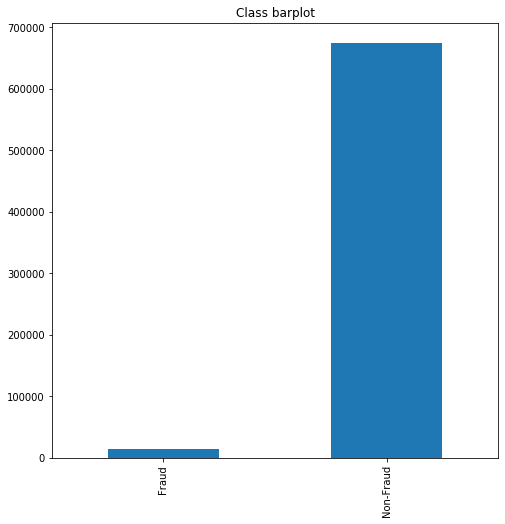

In [23]:
one = (y == 1).sum()
zero = (y == 0).sum()
y_bars = pd.Series([one, zero], index=['Fraud', 'Non-Fraud'])

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
y_bars.plot(kind='bar', title='Class barplot')
plt.show()

Using TensorFlow backend.


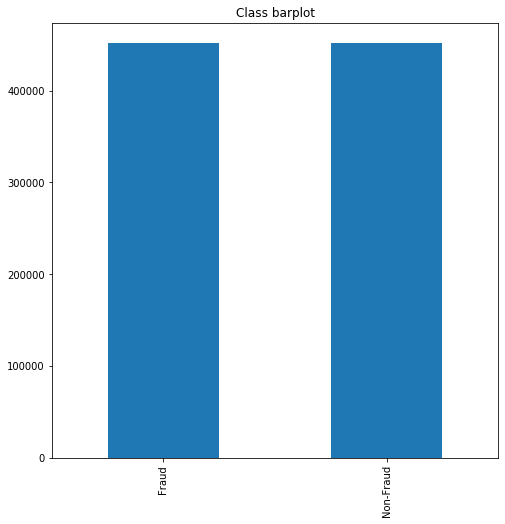

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) #train-test split
X_train = X_train.to_numpy()
from imblearn.over_sampling import SMOTE
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
one = (y_train == 1).sum()
zero = (y_train == 0).sum()
y_bars = pd.Series([one, zero], index=['Fraud', 'Non-Fraud'])

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
y_bars.plot(kind='bar', title='Class barplot')
plt.show()

# RANDOM FOREST CLASSIFIER

In [25]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=50, random_state=42)
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.960951354205628

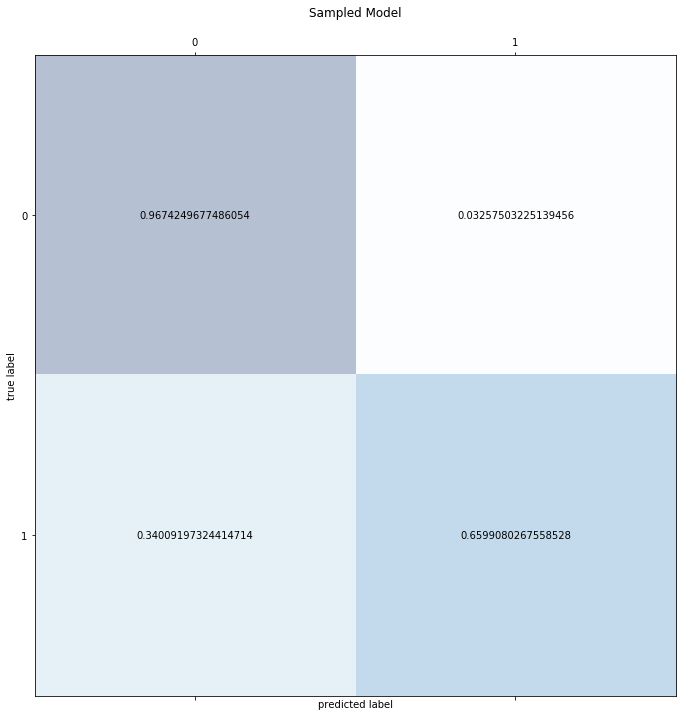


f1 score (macro): unsampled data:0.6977618160241763
f1 score (micro): unsampled data:0.960951354205628


In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
#Sampled Model
# Predict the test data using the best model
y_pred = rfc.predict(X_test)

# Create the confusion matrix 
confmat_resampled = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat_resampled, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_resampled.shape[0]):
    for j in range(confmat_resampled.shape[1]):
        ax.text(x=j, y=i, s=confmat_resampled[i, j], va='center', ha='center')
plt.title('Sampled Model')
plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
plt.show()

#@Macro: Calculate the metrics for each label we have and find their unweighted mean. This does not take label imbalance into account.
#@Micro: Calculate metrics globally by counting the total true positives, false negatives and false positives

f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
print ("\r\nf1 score (macro): unsampled data:" + str(f1_macro))
print ("f1 score (micro): unsampled data:" + str(f1_micro))

QUESTA È ROBA MIA, NON TI SERVE 

In [28]:
preds = rfc.predict(X_test)
res = pd.DataFrame(X_test)
res['flag'] = pd.Series(preds).to_list()
f = res[res['flag'] == 1].index.to_list()
f0 = frauds['user_id'].to_list()
final_id = np.setdiff1d(f,f0).tolist()[:5]

final_id




['002ad534-53c5-4320-a199-45a2b0a9265a',
 '0031da48-f009-4fde-8288-e8ec96726b0b',
 '005380b0-d940-43c4-ac9f-d142d848aa03',
 '00681dec-2e83-4123-b529-13a6cee1356f',
 '006d7f41-a2e0-49ef-b43e-64a604ee4cf5']